# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, precision_score,
    recall_score
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# Helper functions

In [2]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges'])
    if 'SeniorCitizen' in df.columns:
        df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
    return df


def define_feature_sets(df: pd.DataFrame):
    categorical_columns = [
        'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'
    ]
    numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
    missing_cat = [c for c in categorical_columns if c not in df.columns]
    missing_num = [c for c in numeric_columns if c not in df.columns]
    if missing_cat or missing_num:
        raise ValueError(f"Colunas ausentes no dataset. Categóricas faltando: {missing_cat}; Numéricas faltando: {missing_num}")
    return categorical_columns, numeric_columns


def create_preprocessor(categorical_columns, numeric_columns) -> ColumnTransformer:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_columns),
            ('num', StandardScaler(), numeric_columns)
        ]
    )
    return preprocessor


def calculate_ks_statistic(y_true: np.ndarray, y_proba: np.ndarray):
    class_0_proba = y_proba[y_true == 0]
    class_1_proba = y_proba[y_true == 1]
    ks_stat, p_value = stats.ks_2samp(class_0_proba, class_1_proba)
    return ks_stat, p_value


def evaluate_model(model, X, y, model_name: str, split_name: str):
    print(f"\n{'='*50}")
    print(f"AVALIAÇÃO DO MODELO: {model_name} | SPLIT: {split_name}")
    print(f"{'='*50}")
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    ks_stat, ks_p_value = calculate_ks_statistic(y, y_proba)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"KS Statistic: {ks_stat:.4f} (p-value: {ks_p_value:.4f})")
    cm = confusion_matrix(y, y_pred)
    print(f"\nMatriz de Confusão:\n{cm}")
    print(f"\nRelatório de Classificação:")
    print(classification_report(y, y_pred))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fpr, tpr, _ = roc_curve(y, y_proba)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_xlabel('Taxa de Falsos Positivos')
    ax1.set_ylabel('Taxa de Verdadeiros Positivos')
    ax1.set_title(f'Curva ROC - {model_name} ({split_name})')
    ax1.legend()
    ax1.grid(True)
    precision_curve, recall_curve, _ = precision_recall_curve(y, y_proba)
    ax2.plot(recall_curve, precision_curve, label=f'{model_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Curva Precision-Recall - {model_name} ({split_name})')
    ax2.legend()
    ax2.grid(True)
    ax3.hist(y_proba[y == 0], bins=30, alpha=0.7, label='Não Churn', density=True)
    ax3.hist(y_proba[y == 1], bins=30, alpha=0.7, label='Churn', density=True)
    ax3.set_xlabel('Probabilidade Predita')
    ax3.set_ylabel('Densidade')
    ax3.set_title(f'Distribuição das Probabilidades - {model_name} ({split_name})')
    ax3.legend()
    ax3.grid(True)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Matriz de Confusão - {model_name} ({split_name})')
    ax4.set_xlabel('Predito')
    ax4.set_ylabel('Real')
    plt.tight_layout()
    plt.show()
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'ks_statistic': ks_stat,
        'ks_p_value': ks_p_value
    }


# Pipeline

In [7]:
def main():
    print("INICIANDO PIPELINE COM PRÉ-PROCESSAMENTO")
    print("="*70)
    file_path = '../_data/customer_churn_telecom_services.csv'
    df = load_and_preprocess_data(file_path)
    if set(df['Churn'].unique()) == {'Yes', 'No'}:
        y = df['Churn'].map({'No': 0, 'Yes': 1})
    else:
        y = df['Churn']
    categorical_columns, numeric_columns = define_feature_sets(df)
    X = df.drop(columns='Churn')
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp
    )
    print("\nTamanhos dos conjuntos:")
    print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")
    print(f"Distribuição no treino: {y_train.value_counts().to_dict()}")
    print(f"Distribuição na validação: {y_val.value_counts().to_dict()}")
    print(f"Distribuição no teste: {y_test.value_counts().to_dict()}")
    preprocessor = create_preprocessor(categorical_columns, numeric_columns)
    from sklearn.ensemble import RandomForestClassifier
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced'
        ))
    ])
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss'
        ))
    ])
    print(f"\n{'='*70}")
    print("TREINANDO MODELOS...")
    print(f"{'='*70}")
    print("Treinando Random Forest...")
    rf_pipeline.fit(X_train, y_train)
    print("Treinando XGBoost...")
    xgb_pipeline.fit(X_train, y_train)
    print(f"\n{'='*70}")
    print("AVALIANDO EM VALIDAÇÃO...")
    print(f"{'='*70}")
    rf_val_results = evaluate_model(rf_pipeline, X_val, y_val, "Random Forest", "Validação")
    xgb_val_results = evaluate_model(xgb_pipeline, X_val, y_val, "XGBoost", "Validação")
    print(f"\n{'='*70}")
    print("AVALIANDO EM TESTE...")
    print(f"{'='*70}")
    rf_test_results = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest", "Teste")
    xgb_test_results = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost", "Teste")
    best_model_name = 'Random Forest' if rf_val_results['f1_score'] > xgb_val_results['f1_score'] else 'XGBoost'
    best_pipeline = rf_pipeline if best_model_name == 'Random Forest' else xgb_pipeline
    print(f"\nMelhor modelo baseado no F1-Score (validação): {best_model_name}")
    if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
        ohe: OneHotEncoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        ohe_feature_names = list(ohe.get_feature_names_out(categorical_columns))
        feature_names = ohe_feature_names + numeric_columns
        importances = best_pipeline.named_steps['classifier'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        print("\nTop 10 features mais importantes:")
        print(feature_importance_df.head(10))
        plt.figure(figsize=(10, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importância')
        plt.title(f'Top 15 Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    print(f"\n{'='*70}")
    print("PIPELINE CONCLUÍDO!")
    print(f"{'='*70}")
    return {
        'rf_pipeline': rf_pipeline,
        'xgb_pipeline': xgb_pipeline,
        'rf_val_results': rf_val_results,
        'xgb_val_results': xgb_val_results,
        'rf_test_results': rf_test_results,
        'xgb_test_results': xgb_test_results,
        'best_model': best_pipeline,
        'best_model_name': best_model_name,
        'splits': (X_train, y_train, X_val, y_val, X_test, y_test)
    }


INICIANDO PIPELINE COM PRÉ-PROCESSAMENTO

Tamanhos dos conjuntos:
Treino: 4500 | Validação: 1125 | Teste: 1407
Distribuição no treino: {0: 3304, 1: 1196}
Distribuição na validação: {0: 826, 1: 299}
Distribuição no teste: {0: 1033, 1: 374}

TREINANDO MODELOS...
Treinando Random Forest...
Treinando XGBoost...

AVALIANDO EM VALIDAÇÃO...

AVALIAÇÃO DO MODELO: Random Forest | SPLIT: Validação
Precision: 0.5432
Recall: 0.6722
F1-Score: 0.6009
AUC-ROC: 0.8333
KS Statistic: 0.5441 (p-value: 0.0000)

Matriz de Confusão:
[[657 169]
 [ 98 201]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       826
           1       0.54      0.67      0.60       299

    accuracy                           0.76      1125
   macro avg       0.71      0.73      0.72      1125
weighted avg       0.78      0.76      0.77      1125



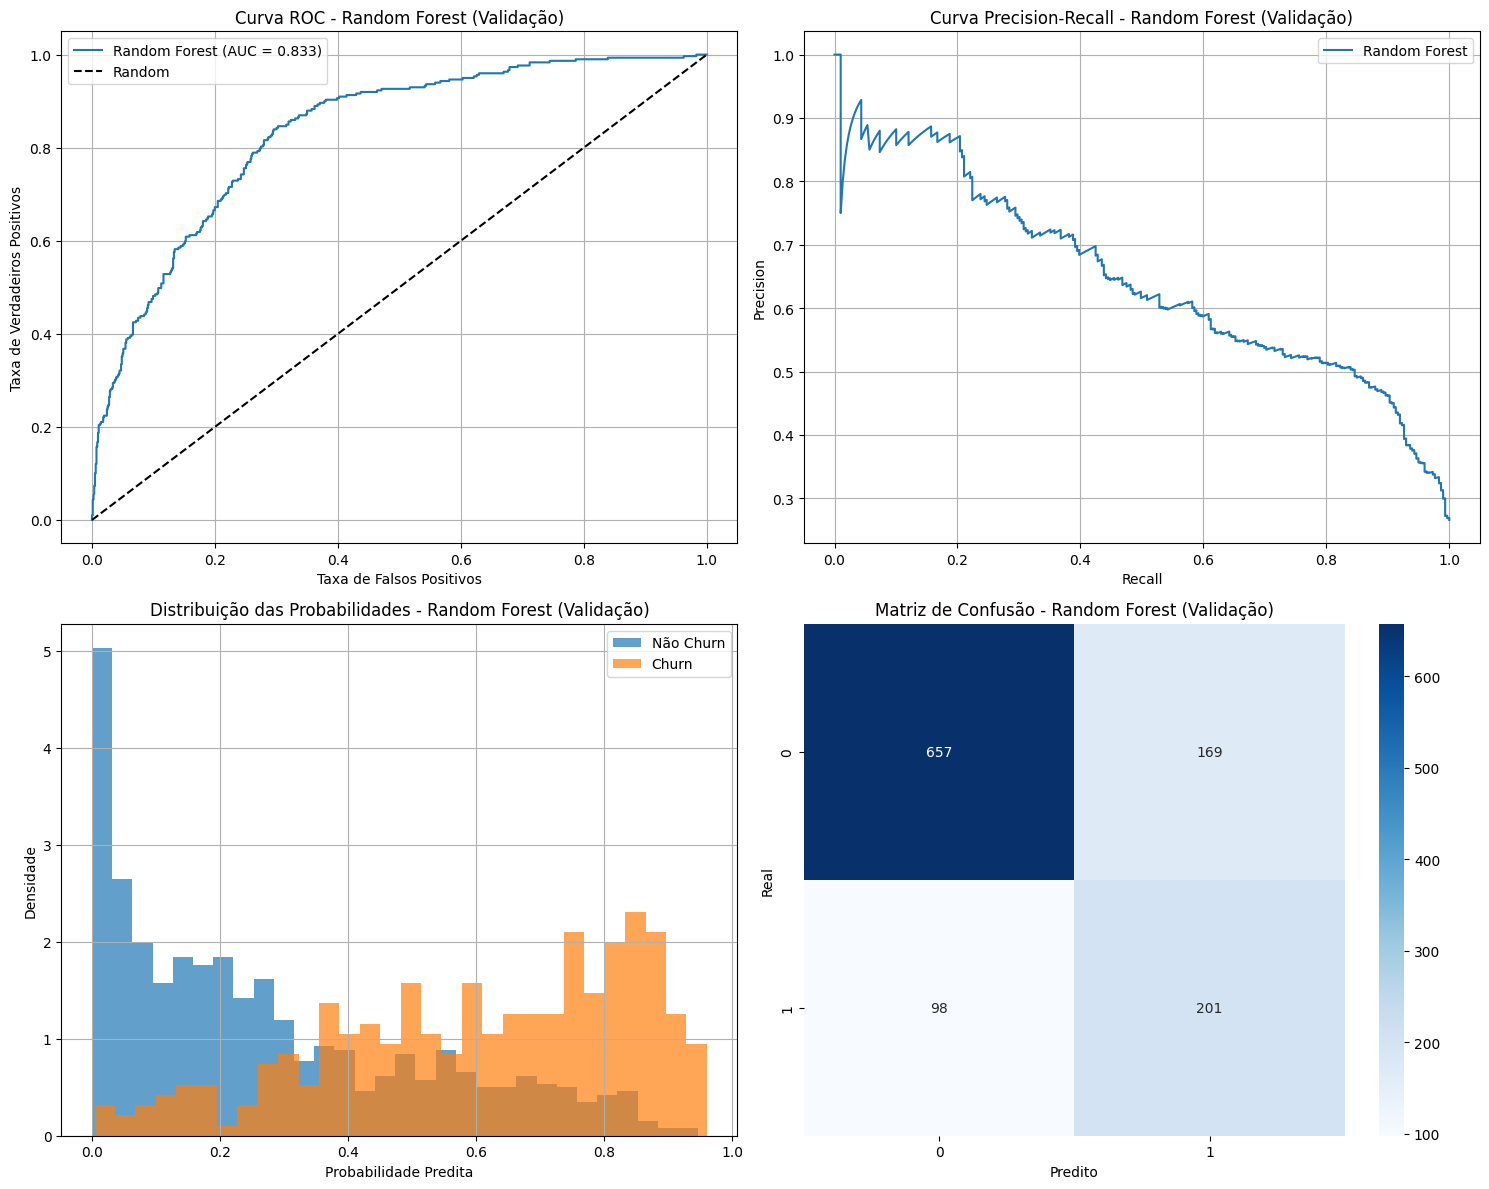


AVALIAÇÃO DO MODELO: XGBoost | SPLIT: Validação
Precision: 0.6164
Recall: 0.4783
F1-Score: 0.5386
AUC-ROC: 0.8202
KS Statistic: 0.4834 (p-value: 0.0000)

Matriz de Confusão:
[[737  89]
 [156 143]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       826
           1       0.62      0.48      0.54       299

    accuracy                           0.78      1125
   macro avg       0.72      0.69      0.70      1125
weighted avg       0.77      0.78      0.77      1125



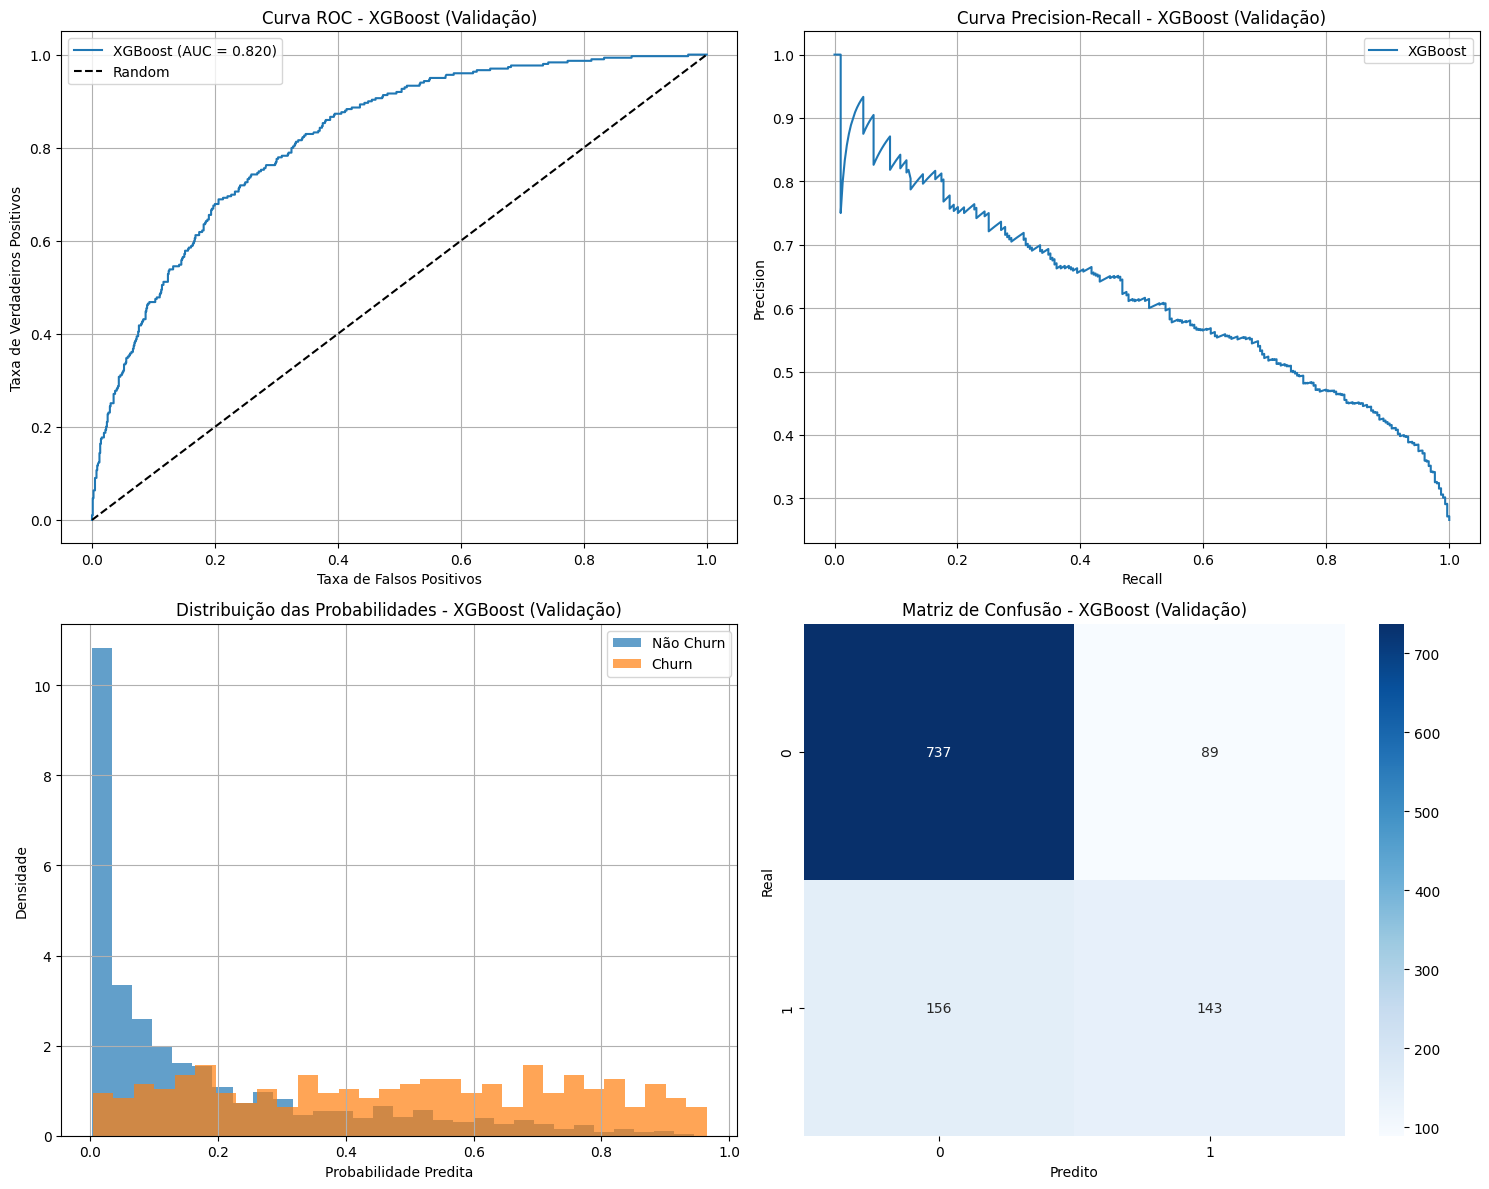


AVALIANDO EM TESTE...

AVALIAÇÃO DO MODELO: Random Forest | SPLIT: Teste
Precision: 0.5519
Recall: 0.7246
F1-Score: 0.6266
AUC-ROC: 0.8360
KS Statistic: 0.5247 (p-value: 0.0000)

Matriz de Confusão:
[[813 220]
 [103 271]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1033
           1       0.55      0.72      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



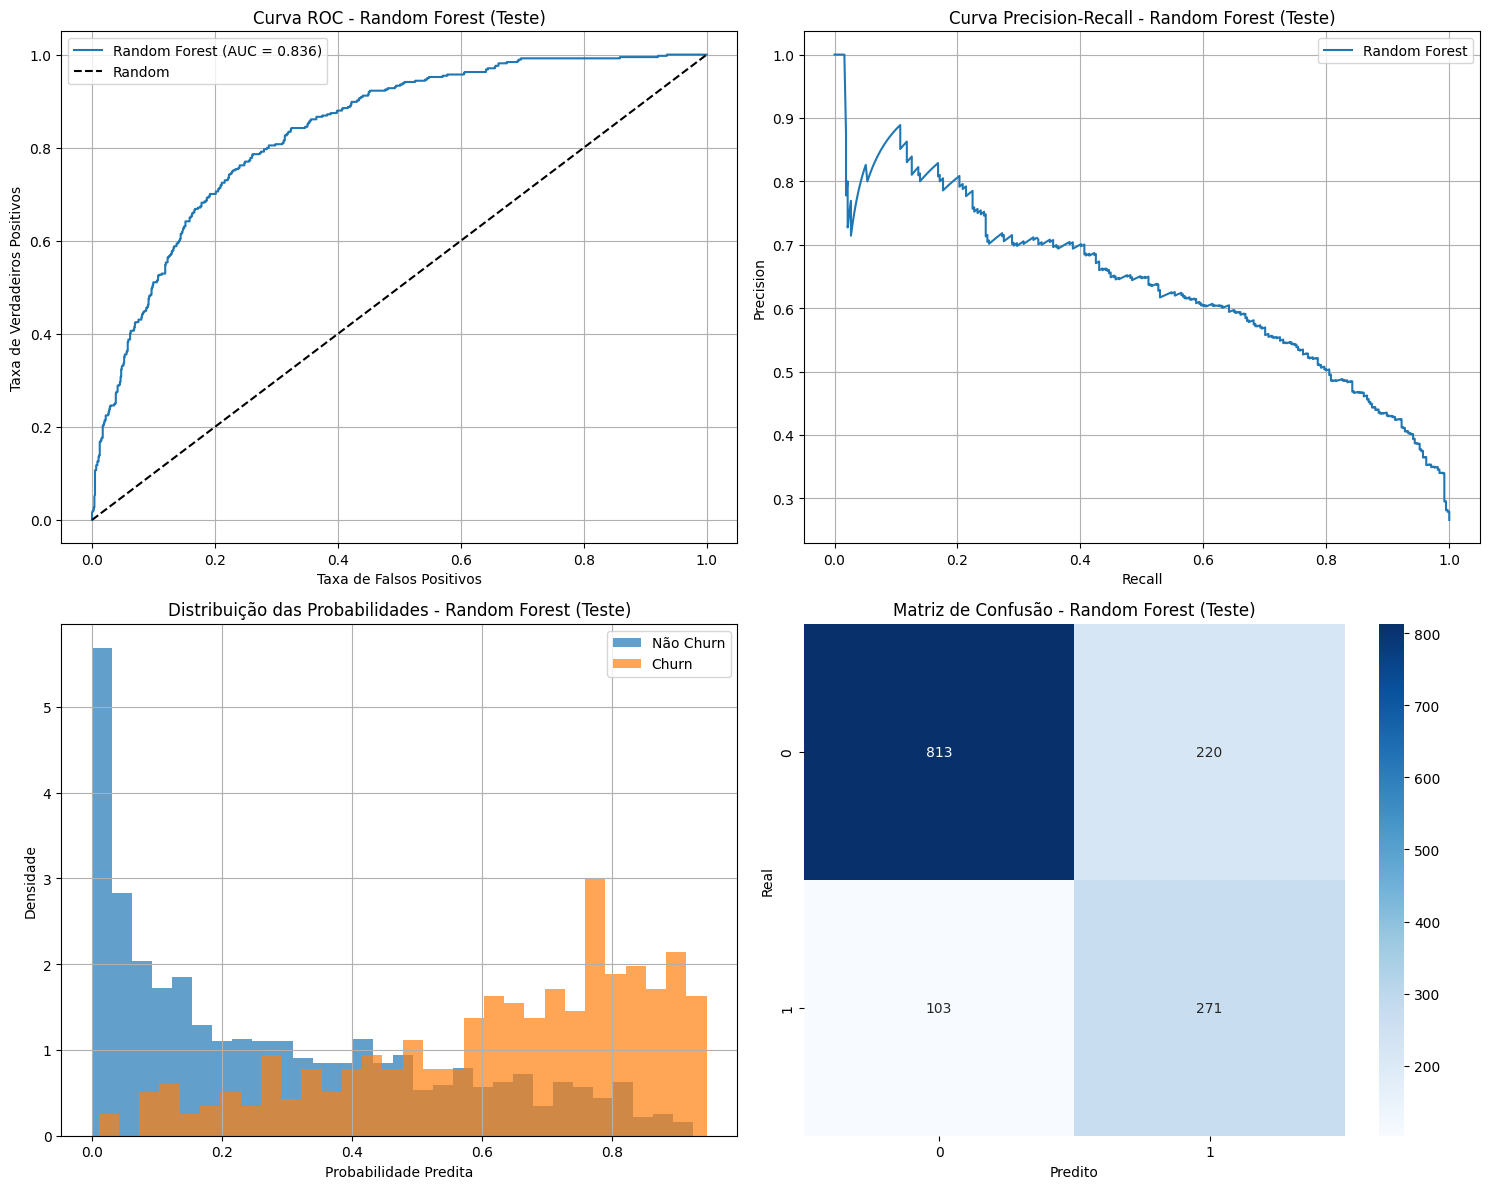


AVALIAÇÃO DO MODELO: XGBoost | SPLIT: Teste
Precision: 0.6025
Recall: 0.5107
F1-Score: 0.5528
AUC-ROC: 0.8237
KS Statistic: 0.4964 (p-value: 0.0000)

Matriz de Confusão:
[[907 126]
 [183 191]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



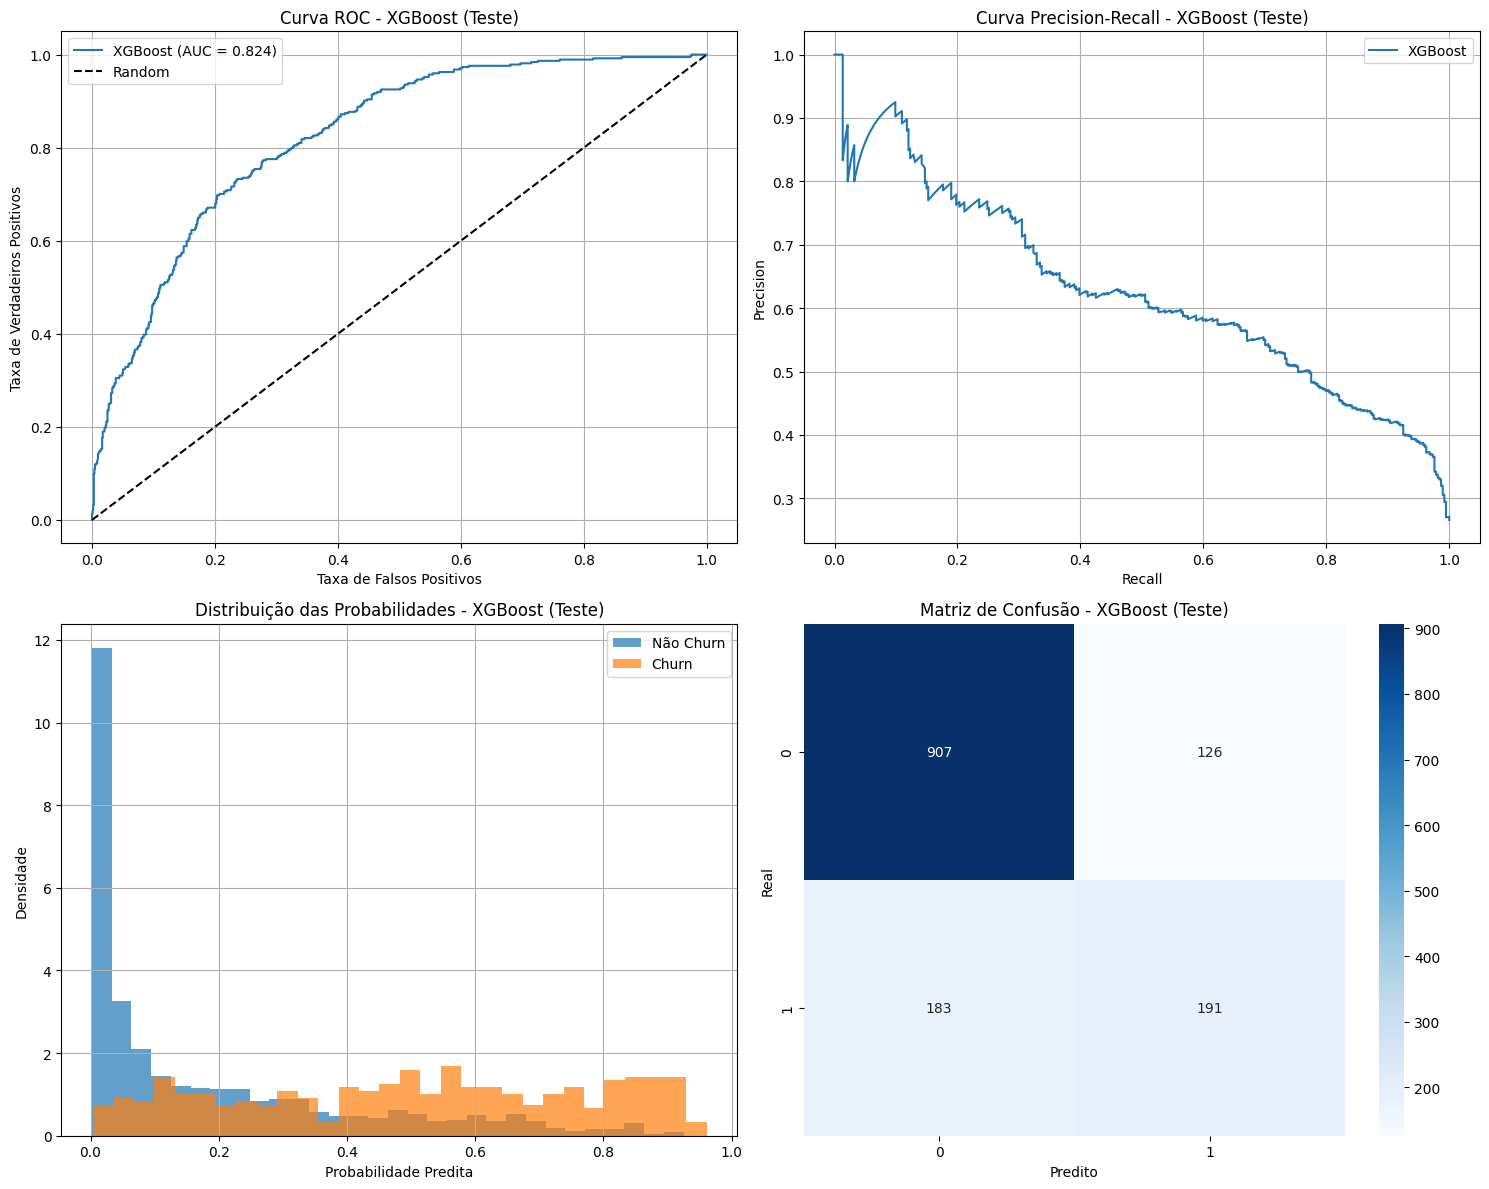


Melhor modelo baseado no F1-Score (validação): Random Forest

Top 10 features mais importantes:
                                feature  importance
27                               tenure    0.191264
29                         TotalCharges    0.147581
28                       MonthlyCharges    0.098049
7           InternetService_Fiber optic    0.078416
22                    Contract_Two year    0.074496
25       PaymentMethod_Electronic check    0.043045
21                    Contract_One year    0.037425
10                   OnlineSecurity_Yes    0.031134
16                      TechSupport_Yes    0.031107
19  StreamingMovies_No internet service    0.020864


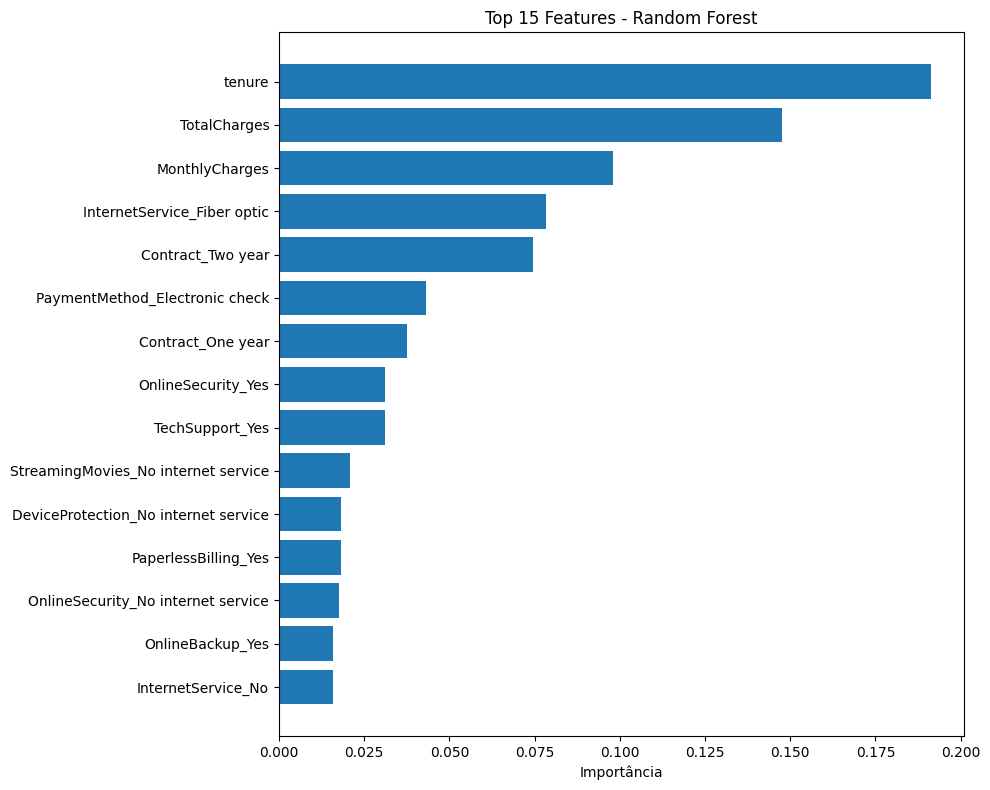


PIPELINE CONCLUÍDO!


In [8]:
if __name__ == "__main__":
    _ = main()
